### Required Libs and Methods


In [17]:
import os, sys
import pickle
import networkx as nx

import numpy as np
import seaborn as sns

from typing import List, Dict
from matplotlib import pyplot as plt

sys.path.append('..')
from utils import calculate_edge_entropy

import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid", {
    "xtick.major.size": 0.1,
    "ytick.major.size": 0.1,
    'grid.linestyle': '--'
 })

sns.despine()

colors = ["blue", "green", "orange", "purple", "darkblue", "pink", "black", "brown", "cyan", "darkblue"]
rounds = np.arange(start=1, stop=10 + 1, step=1)

graph_types = ["chain", "jungle", "full", "collider"]  
edge_probs = [0.1, 0.2, 0.4, 0.6]
er_graphs = [1, 2, 4, 6]
size_main = 30
size_lab = 25
size_ax = 20

def retrieve_federated_data(stored_results_dict, metric='SHD', plot_target='round_metrics') -> np.ndarray:
    """ Return federated information for a specific target.
    
    Note: default is to return information for prior, or the end of the round results.
    """
    return np.asarray([np.array(target_dict[metric], dtype=np.int32) for target_dict in stored_results_dict[plot_target]])


def plot_cluster_experiments_subplots(axs, subplot_idx, num_experiments, repeat_count, 
                                      labels_list, parent_folder_name, 
                                      exps_folder_name, ignore_ids=list(), plot_metric="SHD", 
                                      plot_target='round_metrics', num_rounds=10, std_exageration=1, 
                                      single_legend=False):
    """Plot experiments in a subplot mode"""

    colors = ["blue", "green", "orange", "purple", "darkblue", "pink", "black", "brown", "cyan", "darkblue"]
    rounds = np.arange(start=1, stop=num_rounds + 1, step=1)

    row, col = subplot_idx[0], subplot_idx[1]
    for experiment_id in range(num_experiments):
            if experiment_id in ignore_ids: continue
            
            metrics = list()
            for rep_idx in range(repeat_count):
                data_file_name = f'results_{experiment_id}_{rep_idx}.pickle'
                load_dir = os.path.join('data', parent_folder_name, exps_folder_name, data_file_name)

                with open(load_dir, 'rb') as handle:
                    results_dict = pickle.load(handle)

                metrics.append(retrieve_federated_data(results_dict, plot_metric, plot_target))

            metrics_avg = np.mean(np.asarray(metrics), axis=0)
            metrics_std = np.std(np.asarray(metrics), axis=0)

            axs[row, col].plot(rounds, metrics_avg, label=labels_list[experiment_id], linestyle='solid', marker='o')
            axs[row, col].fill_between(rounds, metrics_avg - std_exageration * metrics_std,
                                      (metrics_avg + std_exageration * metrics_std),
                                       alpha=0.2)
            
            fig.text(0.5, -0.05, 'Round', ha='center', fontsize=size_lab)
            fig.text(-0.03, 0.5, plot_metric, va='center', rotation='vertical', fontsize=size_lab)
            
            axs[row, col].set_xlim([0.5, 10.5])
            
            axs[row, col].tick_params(axis='x', labelsize=size_ax)
            axs[row, col].tick_params(axis='y', labelsize=size_ax)
            
            start, end = axs[row, col].get_ylim()
            axs[row, col].yaxis.set_ticks(np.arange(0, end, 10).astype(int))
            axs[row, col].xaxis.set_ticks(np.arange(1, 11, 1).astype(int))
    return axs

<Figure size 640x480 with 0 Axes>

### Balanced Interventions structured and rnd graphs




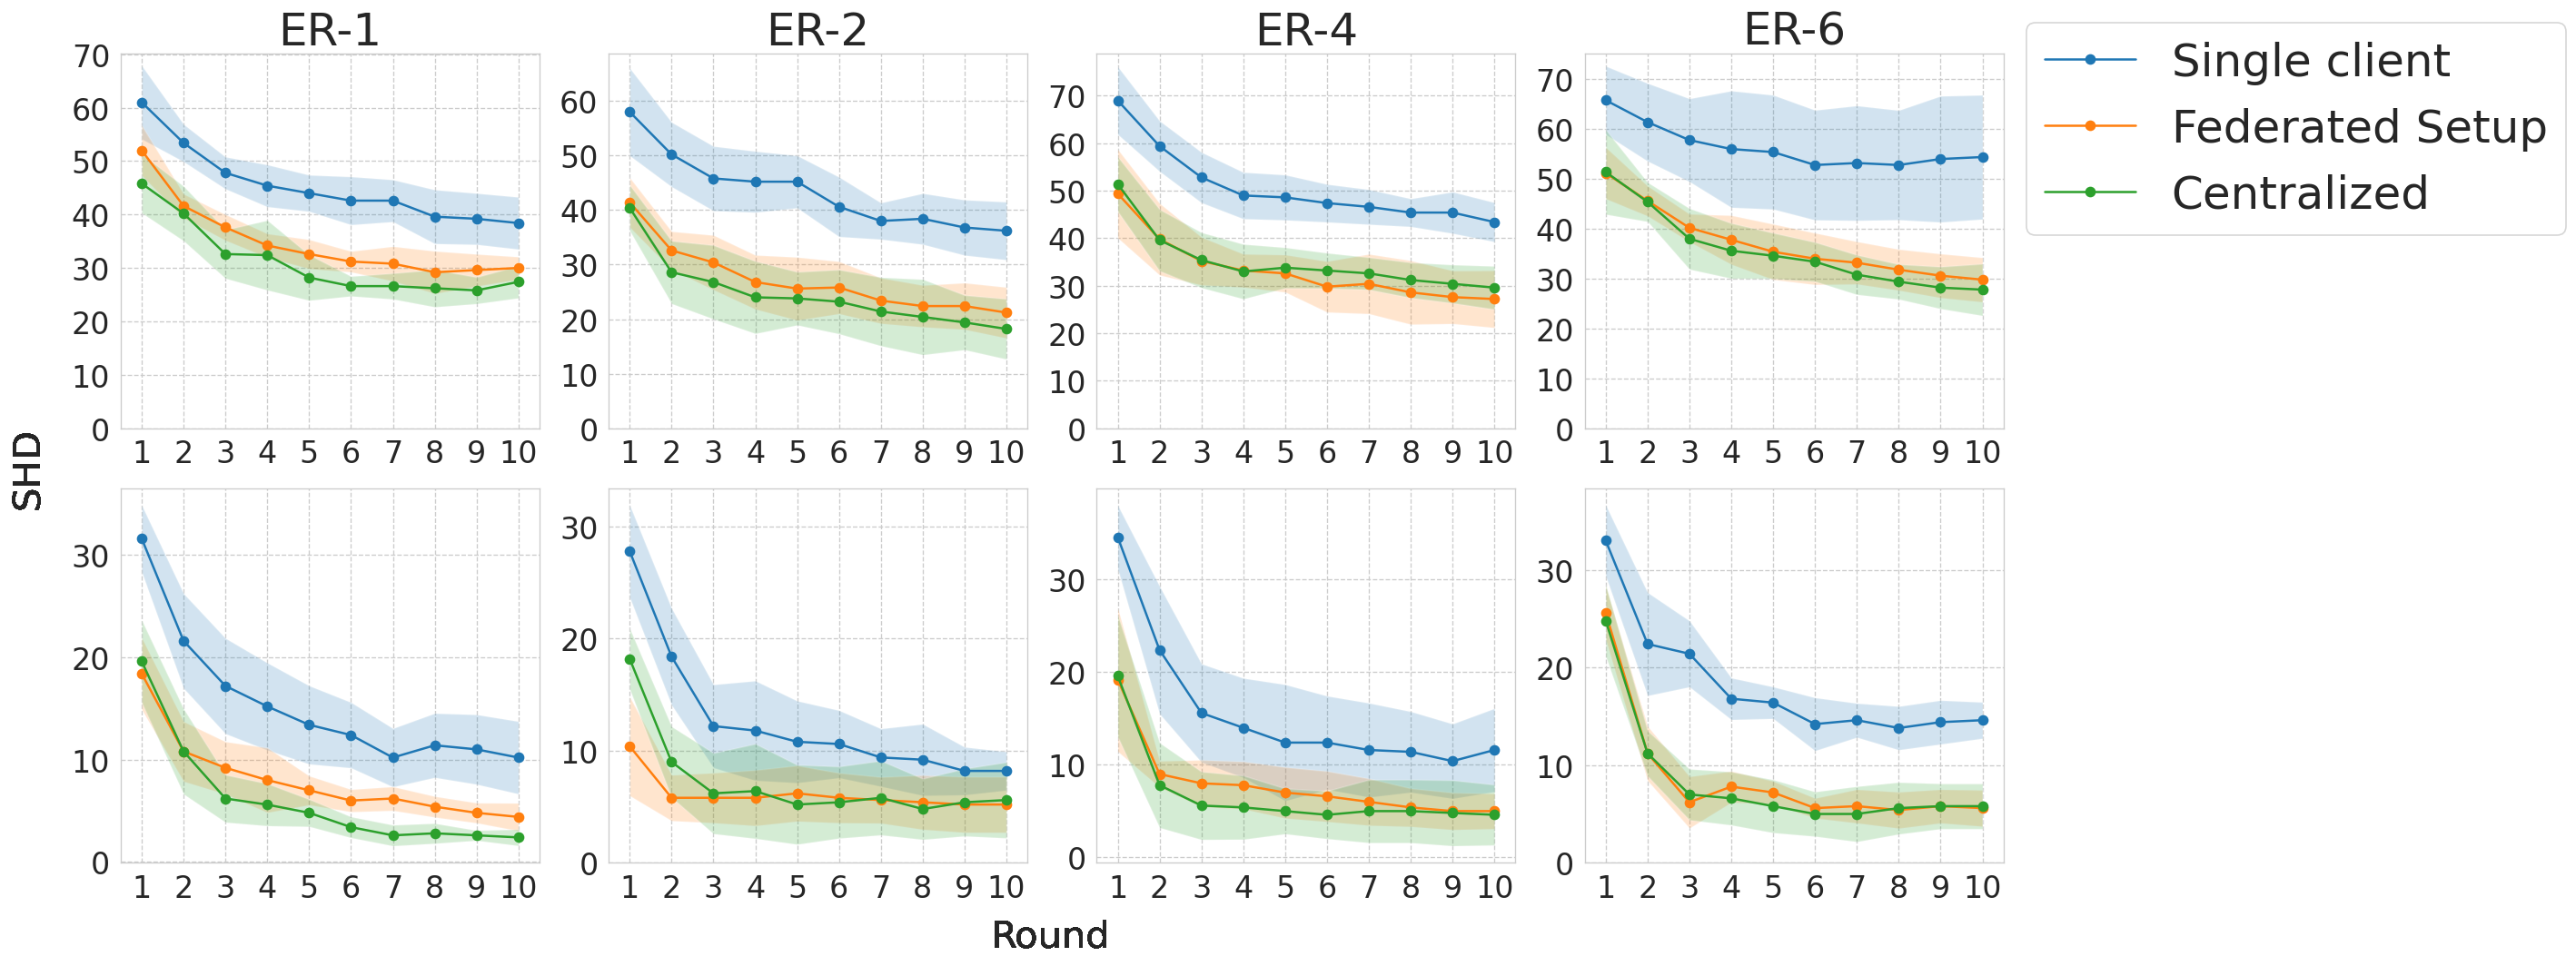

In [4]:
# General Setup
num_experiments, repeat_count = 3, 5
num_vars = 20

# Specific Setup
int_sample_sizes = [5, 10, 20, 40, 60, 80, 100, 120, 160, 200]
experiment_graphs = "rnd"

# Build experiments info
graphs = graph_types if experiment_graphs == "str" else edge_probs
title = "" if experiment_graphs == "str" else "Edge prob.: "

labels = [f'Single client', 'Federated Setup', "Centralized"]

parent_folder_name = 'balanced_str' if experiment_graphs == "str" else "balanced_rnd"
specifiers = [1, 4]

n_row = len(specifiers)
n_col = len(graphs)

fig, axs = plt.subplots(n_row, n_col, figsize=(18, 8), dpi=120)
fig.tight_layout(h_pad=2, w_pad=1.5)

init_samples = [2, 2, 2, 4, 2] if experiment_graphs == "str" else [2, 3, 4, 5, 6]
for row, specifier in enumerate(specifiers):
    for col, graph in enumerate(graphs):
        exps_folder_name = f'BalancedSetup-{graph}-{num_vars}-{specifier}'
        axs = plot_cluster_experiments_subplots (axs, (row, col), num_experiments, repeat_count, 
                                           labels, parent_folder_name, 
                                           exps_folder_name, plot_target='round_metrics')
        title = f'{graph}-20' if experiment_graphs == 'str' else f'ER-{er_graphs[col]}'
        axs[0, col].set_title(title, fontsize=size_main)
axs[0, n_col - 1].legend(loc='center left', bbox_to_anchor=(1.0, 0.8), prop={'size': size_main})
plt.savefig(f'balanced_int_rounds.png', bbox_inches='tight')
plt.show()


#### Structured and random graphs, plot SHD per Int. dataset size

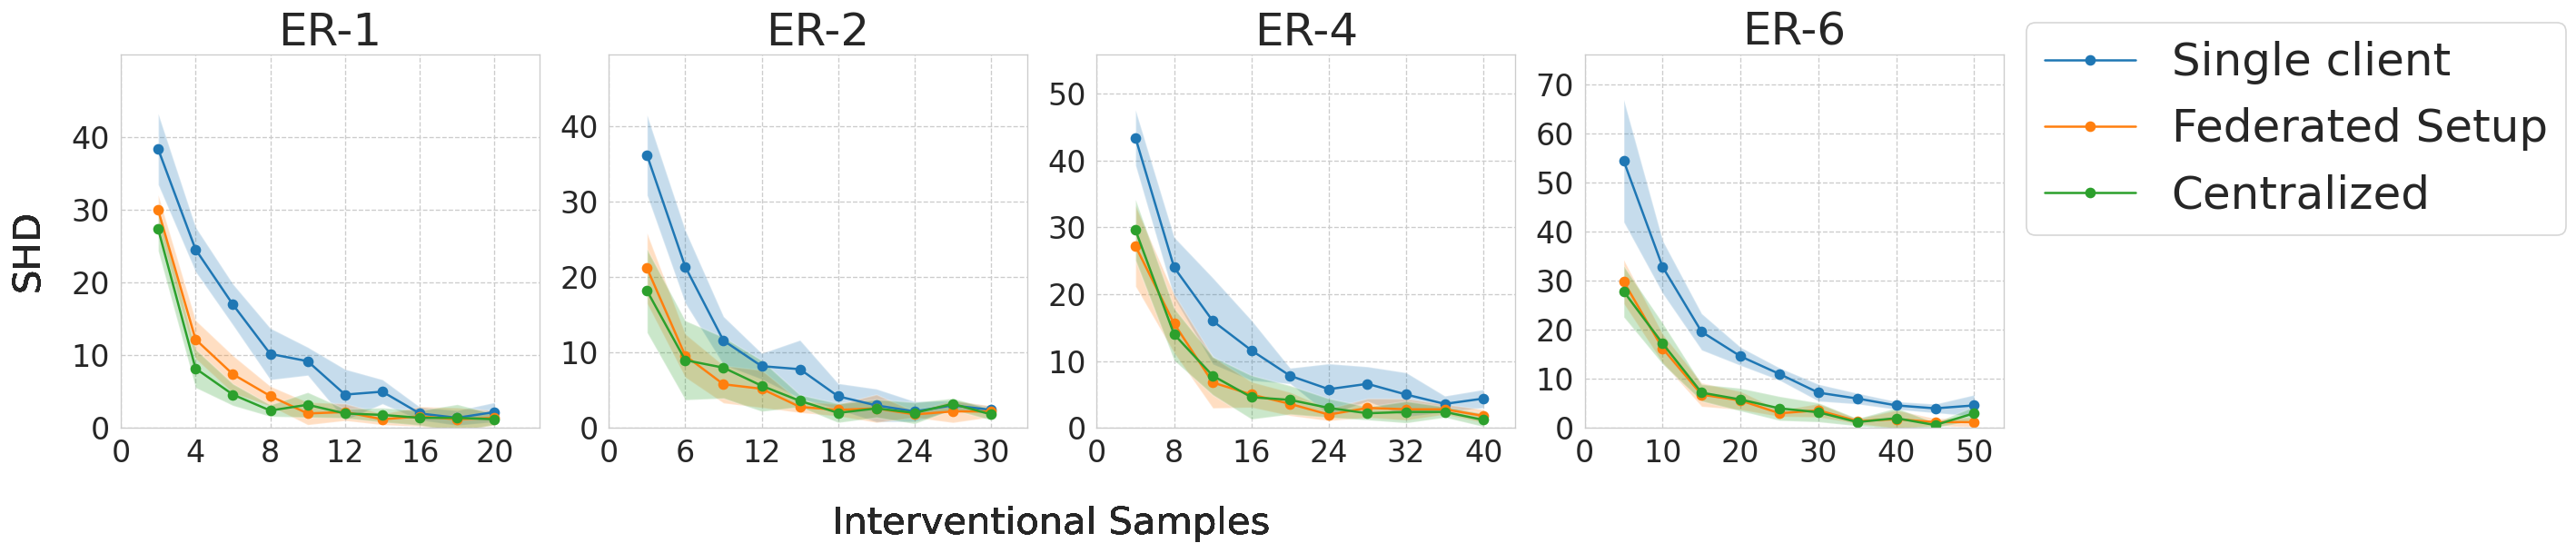

In [94]:
# General Setup
num_experiments, repeat_count = 3, 5
num_vars = 20

# Graphs
experiment_graphs = 'rnd' # or 'str'
graphs = graph_types if experiment_graphs == 'str' else edge_probs  

# Build experiments info
parent_folder_name = f'balanced_{experiment_graphs}'
specifiers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

labels = [f'Single client', 'Federated Setup', 'Centralized']

int_samples_others = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
full_samples = (2 * np.array(int_samples_others)).astype(int)
int_samples_rnd = [2, 3, 4, 5, 6]

n_row = 1
n_col = len(graphs)

fig, axs = plt.subplots(n_row, n_col, figsize=(18, 4), dpi=120)
fig.tight_layout(h_pad=1, w_pad=1.5)

for col, graph in enumerate(graphs):
    if experiment_graphs == 'rnd':
        int_samples = [int_samples_rnd[col] * spc for spc in specifiers]
    else:
        int_samples = full_samples if graph == 'full' else int_samples_others
    
    title = f'{graph}-20' if experiment_graphs == 'str' else f'ER-{er_graphs[col]}'
    axs[col].set_title(title, fontsize=size_main)
    
    for experiment_id in range(num_experiments):
        shd_per_int_samples_list = list()

        for rep_idx in range(repeat_count):
            shd_per_int_samples = list()
            for specifier in specifiers: 
                exps_folder_name = f'BalancedSetup-{graph}-{num_vars}-{specifier}'

                data_file_name = f'results_{experiment_id}_{rep_idx}.pickle'
                load_dir = os.path.join('data', parent_folder_name, exps_folder_name, data_file_name)

                with open(load_dir, 'rb') as handle:
                    results_dict = pickle.load(handle)

                shd_per_rounds = retrieve_federated_data(results_dict, 'SHD', 'round_metrics')
                shd_per_int_samples.append(shd_per_rounds[-1])

            shd_per_int_samples_list.append(shd_per_int_samples)

        shd_per_int_samples_avg = np.mean(np.asarray(shd_per_int_samples_list), axis=0)
        shd_per_int_samples_std = np.std(np.asarray(shd_per_int_samples_list), axis=0)

        axs[col].plot(int_samples, shd_per_int_samples_avg, label=labels[experiment_id], 
                      linestyle='solid', marker='o')
        axs[col].fill_between(int_samples, shd_per_int_samples_avg - shd_per_int_samples_std,
                              (shd_per_int_samples_avg +  shd_per_int_samples_std),
                               alpha=0.25)

        fig.text(0.5, -0.15, 'Interventional Samples', ha='center', fontsize=size_lab)
        fig.text(-0.03, 0.5, 'SHD', va='center', rotation='vertical', fontsize=size_lab)

        start_x, end_x = axs[col].get_xlim()
        start_y, end_y = axs[col].get_ylim()

        axs[col].set_xlim([start_x + 0.5, end_x + 0.5])
        axs[col].set_ylim([0, end_y + 2])
        
        axs[col].tick_params(axis='x', labelsize=size_ax)
        axs[col].tick_params(axis='y', labelsize=size_ax)

        axs[col].yaxis.set_ticks(np.arange(0, end_y, 10).astype(int))
        if graph == 'full':  axs[col].xaxis.set_ticks(np.arange(0, end_x, end_x // 5).astype(int))
        else: axs[col].xaxis.set_ticks(np.arange(0, end_x, end_x // 5).astype(int))
axs[n_col - 1].legend(loc='center left', bbox_to_anchor=(1.0, 0.8), prop={'size': size_main})

plt.savefig(f'balanced_int_dataset.png', bbox_inches='tight')
plt.show()


### Client number effect balanced scenario


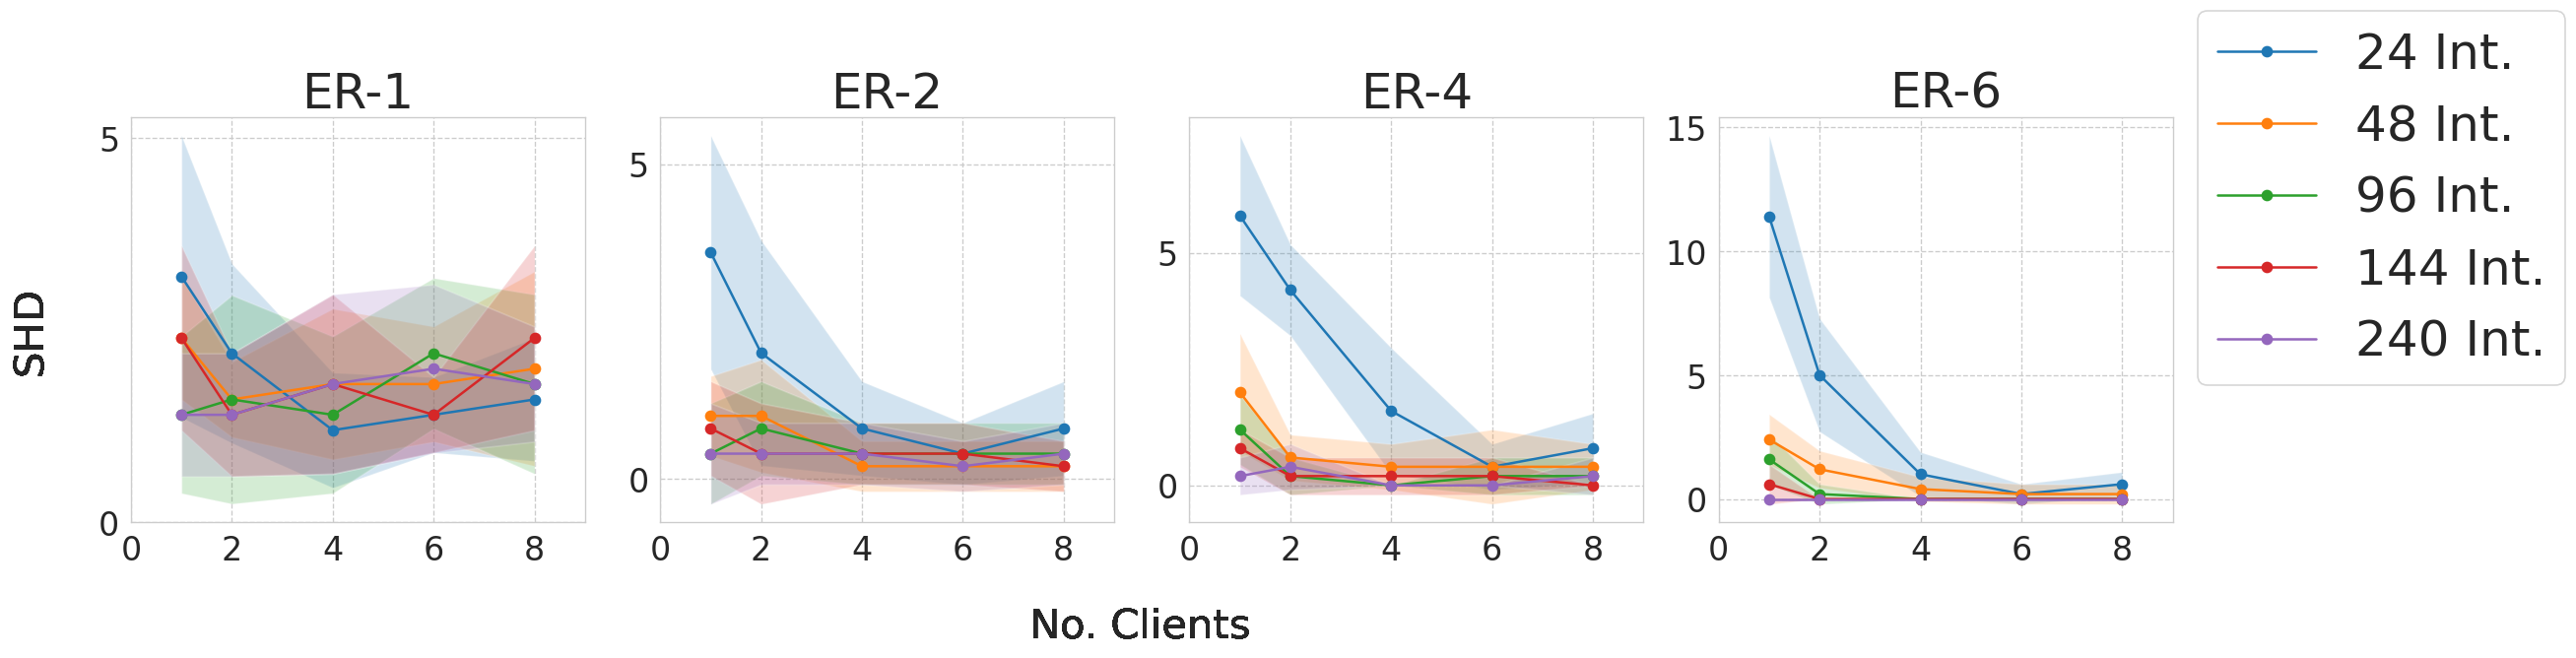

In [100]:
# General Setup
num_experiments, repeat_count = 5, 5
num_vars = 20

# Graphs
experiment_graphs = 'rnd' # or str
division_type = 'NODIV' # or NODIV

# Build experiments info
graphs = graph_types if experiment_graphs == 'str' else edge_probs

if division_type == 'DIV':
    parent_folder_name = 'client_sweepdiv_str' if experiment_graphs == 'str' else 'client_sweepdiv_rnd'
else: 
    parent_folder_name = 'client_sweep_str' if experiment_graphs == 'str' else 'client_sweep_rnd'
ref_num_clients = [1, 2, 4, 6, 8]

n_row = 1
n_col = len(graphs)

fig, axs = plt.subplots(n_row, n_col, figsize=(18, 4), dpi=120)
fig.tight_layout(h_pad=1, w_pad=1.5)

for col, graph in enumerate(graphs):
    int_samples = [24, 48, 96, 144, 240]
    title = f'{graph}-20' if experiment_graphs == 'str' else f'ER-{er_graphs[col]}'
    axs[col].set_title(title, fontsize=size_main)

    for int_sample in int_samples:
        if division_type == 'DIV':
            exps_folder_name = f'ClientSweepDiv-{graph}-{num_vars}-{int_sample}'
        else:
            exps_folder_name = f'ClientSweep-{graph}-{num_vars}-{int_sample}'
        
        shd_per_numclients = list()
        for rep_idx in range(repeat_count):
            shd_per_clients = list()
            
            for experiment_id in range(num_experiments):
                data_file_name = f'results_{experiment_id}_{rep_idx}.pickle'
                load_dir = os.path.join('data', parent_folder_name, exps_folder_name, data_file_name)

                with open(load_dir, 'rb') as handle:
                    results_dict = pickle.load(handle)

                shd_per_rounds = retrieve_federated_data(results_dict, 'SHD', 'round_metrics')
                shd_per_clients.append(shd_per_rounds[-1])
            
            shd_per_numclients.append(shd_per_clients)

        shd_per_numclients_avg = np.mean(np.asarray(shd_per_numclients), axis=0)
        shd_per_numclients_std = np.std(np.asarray(shd_per_numclients), axis=0)

        axs[col].plot(ref_num_clients, shd_per_numclients_avg, label=f'{int_sample} Int.', 
                      linestyle='solid', marker='o')
        axs[col].fill_between(ref_num_clients, shd_per_numclients_avg - shd_per_numclients_std,
                              (shd_per_numclients_avg +  shd_per_numclients_std),
                               alpha=0.2)
        
        fig.text(0.5, -0.15, 'No. Clients', ha='center', fontsize=size_lab)
        fig.text(-0.03, 0.5, 'SHD', va='center', rotation='vertical', fontsize=size_lab)

        axs[col].set_xlim([0, 9])

        start, end = axs[col].get_ylim()
        axs[col].yaxis.set_ticks(np.arange(0, end, 5).astype(int))
        axs[col].xaxis.set_ticks(np.arange(0, 10, 2).astype(int))
        
        axs[col].tick_params(axis='x', labelsize=size_ax)
        axs[col].tick_params(axis='y', labelsize=size_ax)
        
axs[n_col - 1].legend(loc='center left', bbox_to_anchor=(1.0, 0.8), prop={'size': size_main})

plt.savefig(f'client_sweep_{division_type.lower()}.png', bbox_inches='tight')
plt.show()

### Toy experiments with structured and random graphs

Plotting for aps-50-50
Plotting for aps-20-80


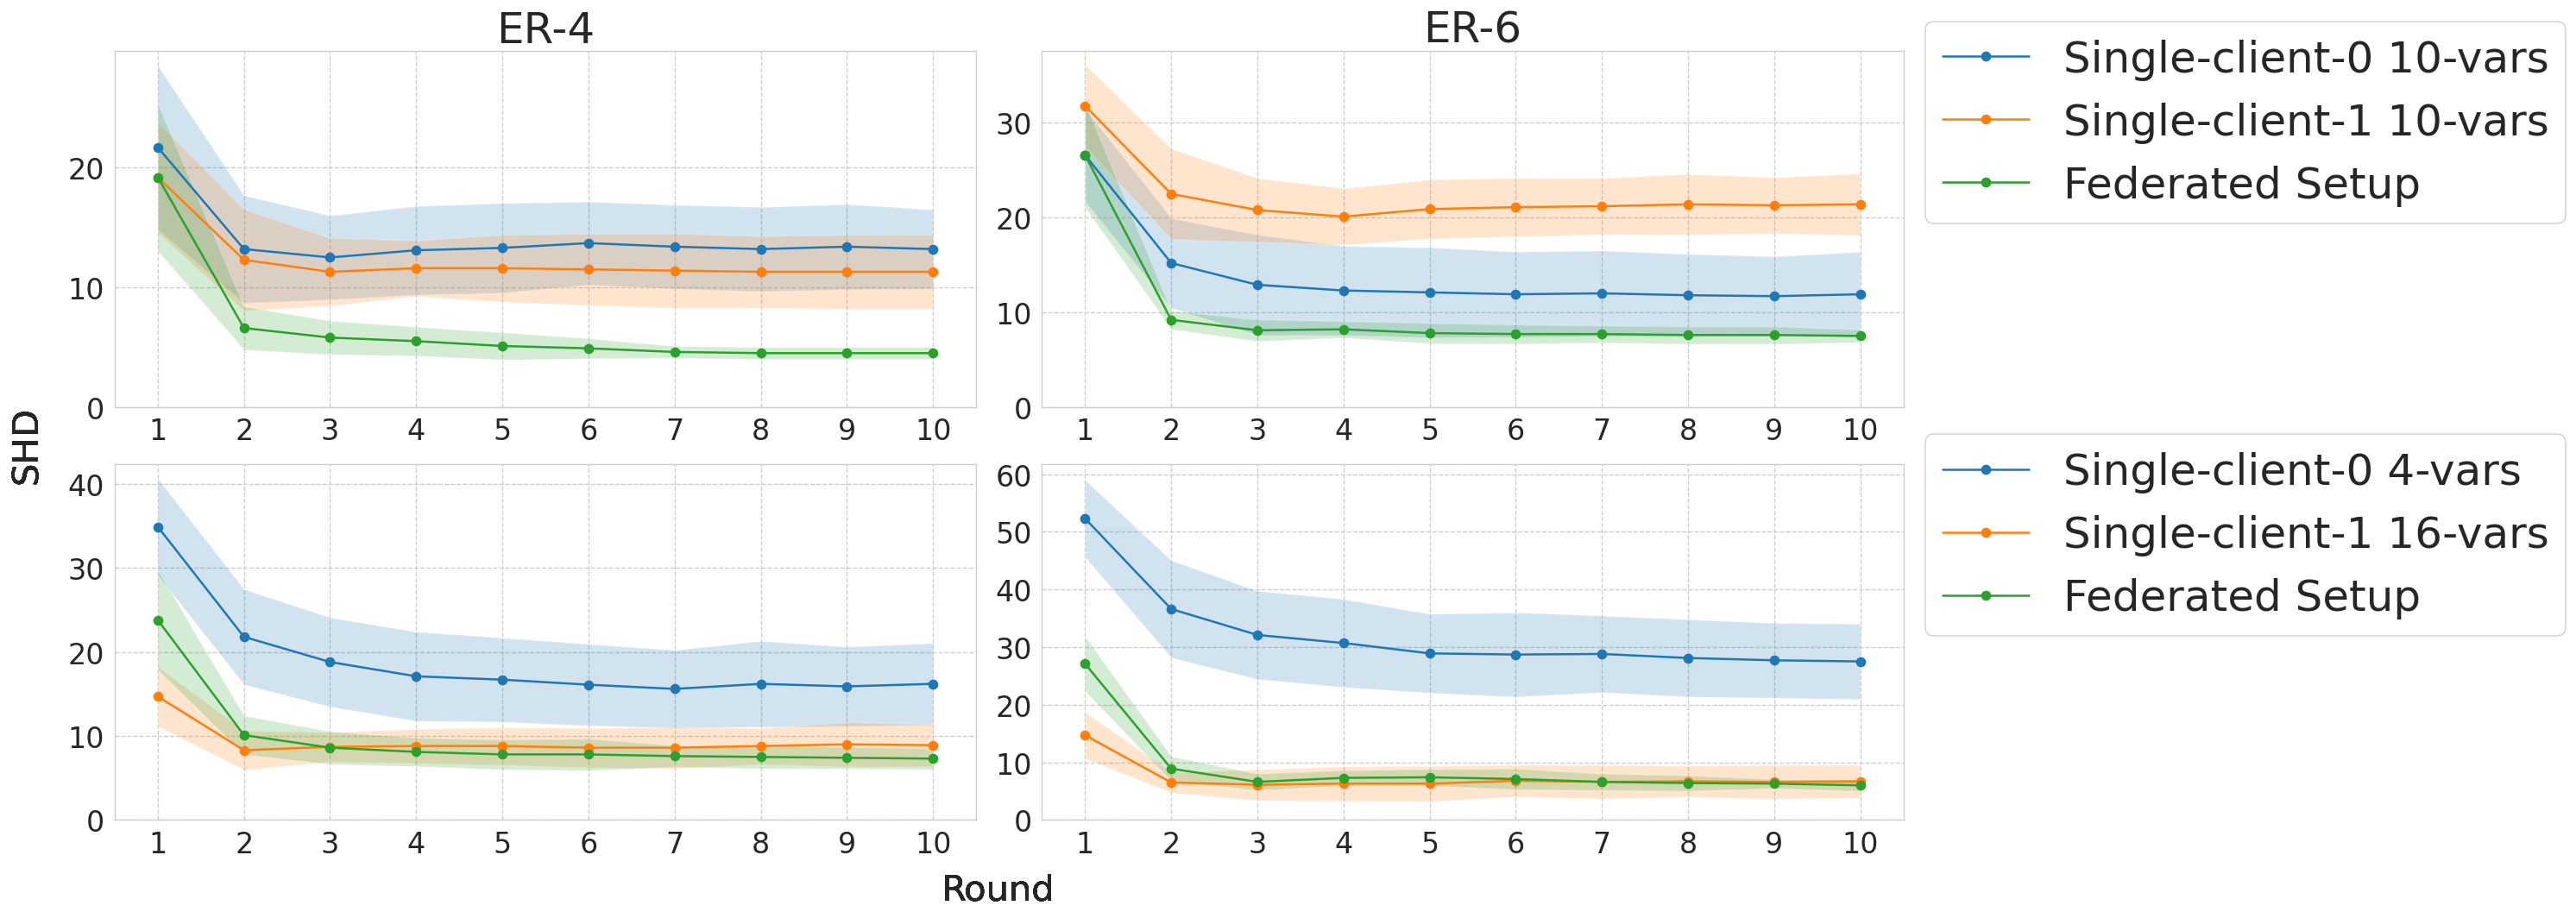

In [18]:
# General Setup
num_experiments, num_rounds, repeat_count, plot_metric, std_exageration = 3, 10, 10, 'SHD', 1
num_vars = 20

# Specific Setup
experiment_graphs = 'rnd'
splits = [(50, 50), (20, 80)]
parent_folder_name = 'unbalanced_str' if experiment_graphs == 'str' else 'unbalanced_rnd'
specifiers = [f'aps-{split[0]}-{split[1]}' for split in splits]

# Graphs
edge_probs = [0.1, 0.2, 0.4, 0.6] # redefine edge probs here since 0.1 is not reasonable!

# Build experiments info
graphs = graph_types if experiment_graphs == 'str' else edge_probs
title = '' if experiment_graphs == 'str' else 'Edge prob.: '

intervention_labels = [[f'Single-client-0 {int((50 / 100) * num_vars)}-vars', 
                        f'Single-client-1 {int((50 / 100) * num_vars)}-vars', 
                        'Federated Setup'],
                       [f'Single-client-0 {int((20 / 100) * num_vars)}-vars', 
                        f'Single-client-1 {int((80 / 100) * num_vars)}-vars', 
                        'Federated Setup']]

n_row = len(splits)
n_col = len(graphs)

fig, axs = plt.subplots(n_row, n_col, figsize=(18, 8), dpi=120)
fig.tight_layout(h_pad=2, w_pad=1.5)

for row, specifier in enumerate(specifiers):
    print(f'Plotting for {specifier}')
    for col, graph in enumerate(graphs):
        title = f'{graph}-20' if experiment_graphs == 'str' else f'ER-{er_graphs[col]}'
        axs[0, col].set_title(title, fontsize=size_main)
        exps_folder_name = f'ToySetup-{graph}-{num_vars}-{specifier}'
        plot_cluster_experiments_subplots(axs, (row, col), num_experiments, repeat_count, 
                                          intervention_labels[row], parent_folder_name, 
                                          exps_folder_name, plot_target='round_metrics')

axs[0, n_col - 1].legend(loc='center left', bbox_to_anchor=(1.0, 0.8), prop={'size': size_main})
axs[1, n_col - 1].legend(loc='center left', bbox_to_anchor=(1.0, 0.8), prop={'size': size_main})

plt.savefig(f'unbalanced_int_locality.png', bbox_inches='tight')
plt.show()


### Plot graphs per round

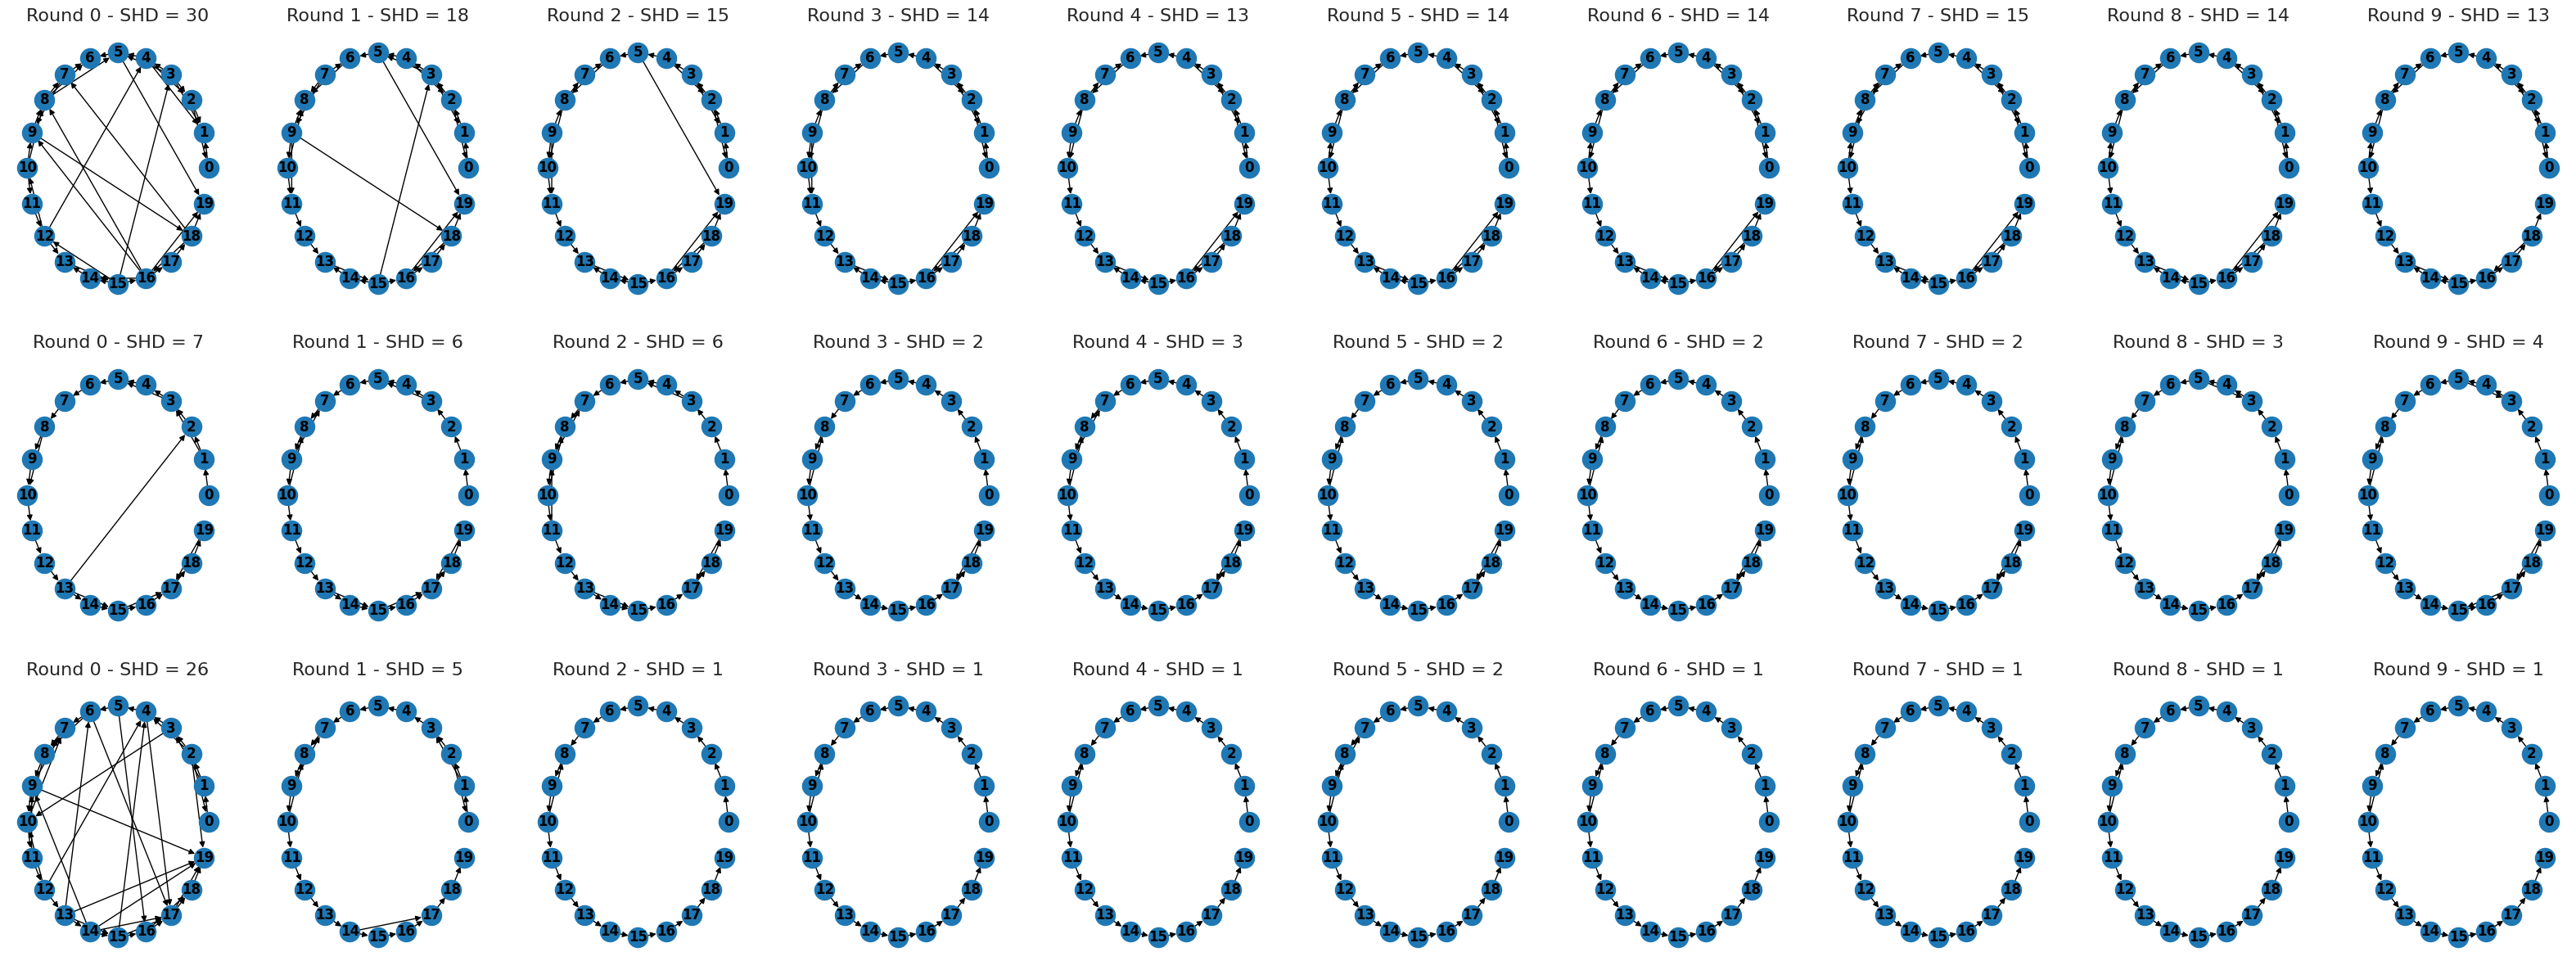

In [16]:
num_rounds = 10
rounds = np.arange(start=0, stop=num_rounds, step=1)

folder_name = "str_toy/ToySetup-chain-20-aps-20-80"
setups = ["Client-0", "Client-1", "Federated Setup"]
n_row = len(setups)
n_col = num_rounds

fig, axs = plt.subplots(n_row, n_col, figsize=(32, 12), dpi=100)
fig.tight_layout(h_pad=2, w_pad=0.5)

for r, setup in enumerate(setups):
    data_file_name = f'results_{r}_1.pickle'
    load_dir = os.path.join('data', folder_name, data_file_name)
    
    with open(load_dir, 'rb') as handle:
        results_dict = pickle.load(handle)

    setup_mats = results_dict['round_adjs']
    setup_shds = results_dict['round_metrics']

    for c in range(n_col):
        graph = nx.DiGraph(setup_mats[c])
        nx.draw_circular(graph, ax=axs[r, c], with_labels=True, font_weight='bold')
        axs[r, c].set_title(f'Round {c} - SHD = {setup_shds[c]["SHD"]}', fontsize=16)
        axs[r, c].set_axis_off()


plt.savefig(f'unbalanced_int_graph_plots.png', bbox_inches='tight')
plt.show()
    


### Average entropy analysis

Total edges to plot: 74
Total edges to plot: 80
Total edges to plot: 102
Total edges to plot: 82


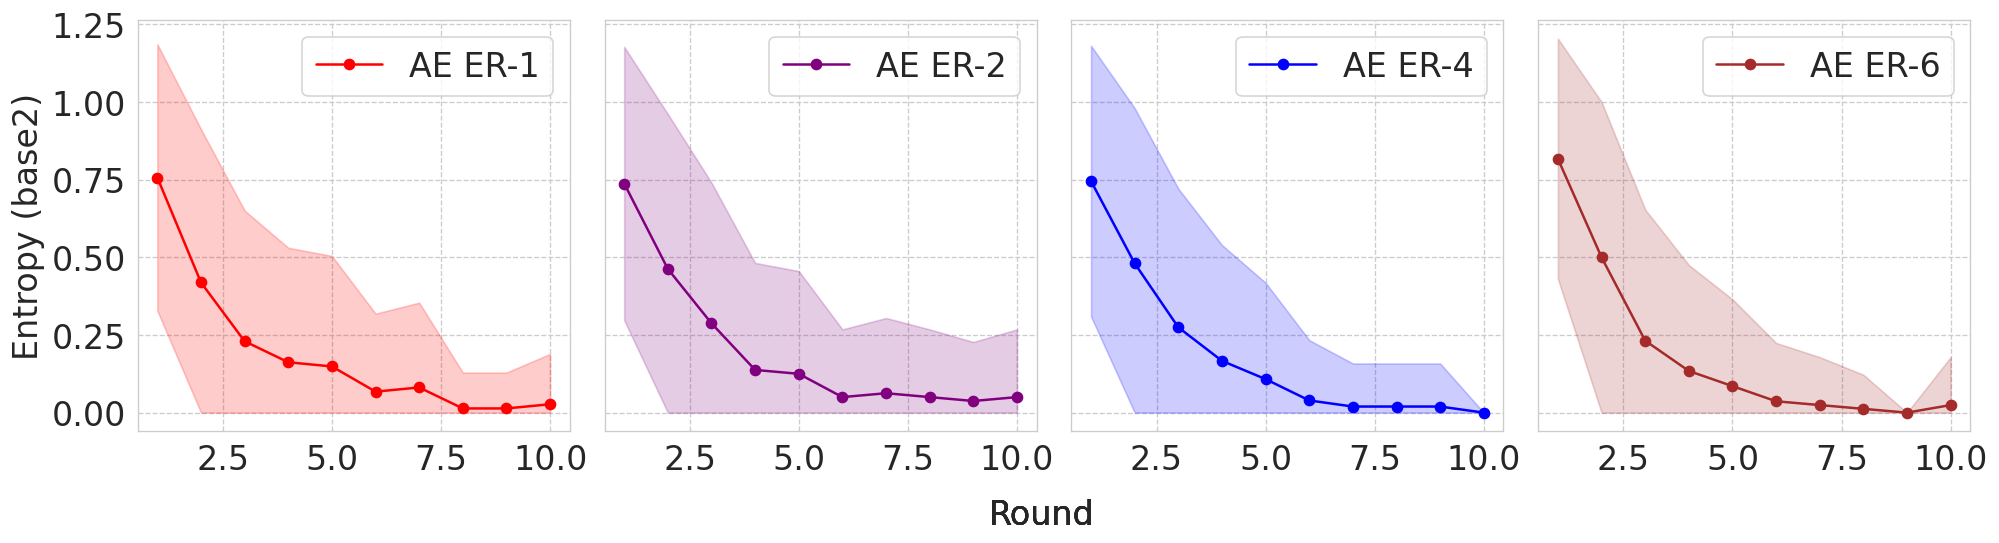

In [98]:
parent_folder_name = 'entropy_rnd'

num_rounds = 10
num_clients = 10

fig, axs = plt.subplots(1, 4, figsize=(16, 4), dpi=120, sharex='all', sharey='all')
fig.tight_layout(h_pad=2, w_pad=0.5)

colors = ['red', 'purple', 'blue', 'brown', 'green']
for idx, edge_prob in enumerate([0.1, 0.2, 0.4, 0.6]):
    folder_name = f'EntropyTest-{edge_prob}-20'
    col = idx % 5

    data_file_name = 'results_0_3.pickle'
    if edge_prob == 0.4: data_file_name = 'results_0_0.pickle'
    if edge_prob == 0.6: data_file_name = 'results_0_1.pickle'
    if edge_prob == 0.2: data_file_name = 'results_0_1.pickle'

    load_dir = os.path.join('data', parent_folder_name, folder_name, data_file_name)
    with open(load_dir, 'rb') as handle:
        results_dict = pickle.load(handle)

    entropy_matrices = list()
    for round_id in range(num_rounds): 
        entropy_matrices.append(calculate_edge_entropy([results_dict['client_0_adjs'][round_id], results_dict['client_1_adjs'][round_id]]))

    mat_size = entropy_matrices[0].shape[0]
    entropy_vals = [mat.ravel() for mat in entropy_matrices]
    plot_mat = np.stack((entropy_vals)).T

    rounds = [round_id for round_id in range(1, 10 + 1)]
    rows = [row for row in range(mat_size * mat_size) if row % mat_size > mat_size / 2 and np.average(plot_mat[row]) > 0.01]
    print(f'Total edges to plot: {len(rows)}')

    avgs_entropy = np.average(plot_mat[rows], axis=0)
    stds_entropy = np.std(plot_mat[rows], axis=0)
    
    axs[col].plot(rounds, avgs_entropy, marker='o', color=colors[idx], label=f'AE ER-{er_graphs[col]}')
    axs[col].fill_between(rounds, [0 if el < 0 else el for el in avgs_entropy - stds_entropy],
                               (avgs_entropy + stds_entropy), alpha=0.2, color=colors[idx])

    axs[0].set_ylabel("Entropy (base2)", fontsize=size_lab - 5)
    axs[col].tick_params(axis='x', labelsize=size_ax)
    axs[col].tick_params(axis='y', labelsize=size_ax)
    axs[col].legend(loc='upper right', fontsize=size_main - 10)
    fig.text(0.5, -0.1, 'Round', ha='center', fontsize=size_lab - 5)

    plt.savefig(f'entropy_analysis.png', bbox_inches='tight')

plt.show()

### Comparing aggregation methods


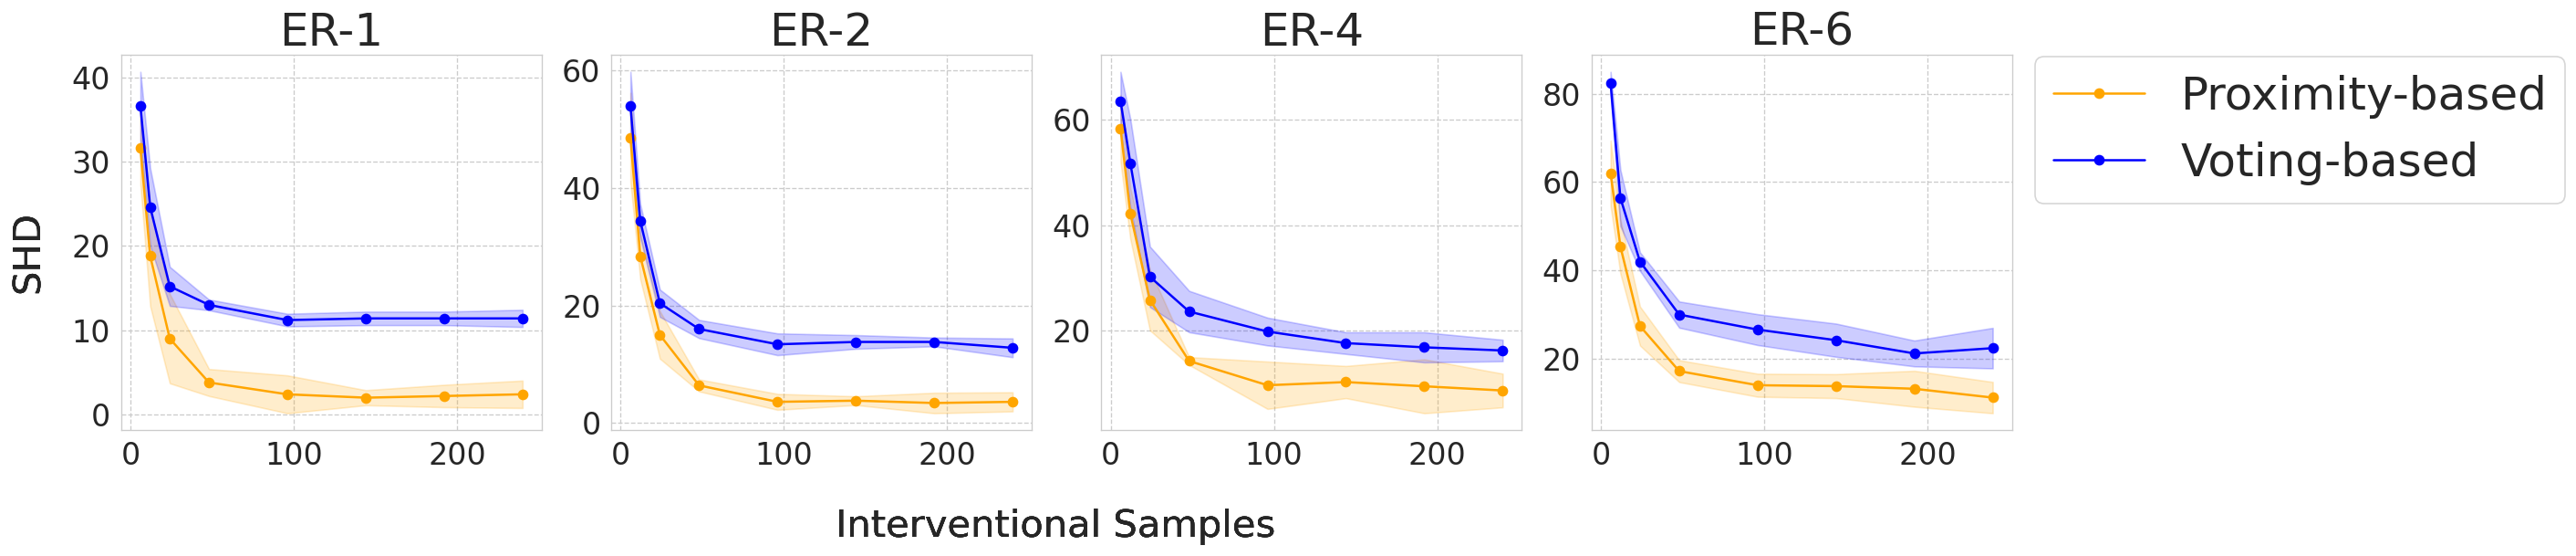

In [99]:
# General setup
num_setups, repeat_count = 4, 5
num_vars = 20

# Graphs and aggregation
edge_prob = 0.6
alpha = 0.5
graphs = edge_probs

# Build experiments info
experiment_graphs = "rnd"
agg_methods, vars_per_client = ['locality', 'naive'], 2
parent_folder_name = 'aggregation_comp'
int_data_sizes = [6, 12, 24, 48, 96, 144, 192, 240]

n_row = 1
n_col = len(edge_probs)

fig, axs = plt.subplots(n_row, n_col, figsize=(18, 4), dpi=120)
fig.tight_layout(h_pad=1, w_pad=1.5)

for col, graph in enumerate(graphs):
    for agg_method in agg_methods:
        color = 'blue' if agg_method == 'naive' else 'orange'
        exps_folder_name = f'AggComparison-{graph}-{num_vars}-{agg_method}-{alpha}-{vars_per_client}'
        title = f'{graph}-20' if experiment_graphs == 'str' else f'ER-{er_graphs[col]}'
        axs[col].set_title(title, fontsize=size_main)
        avgs, stds = [], []
        for exp_idx, int_samples in enumerate(int_data_sizes):
            shd_per_rounds_list = list()
            for rep_idx in range(repeat_count):
                data_file_name = f'results_{exp_idx}_{rep_idx}.pickle'
                load_dir = os.path.join('data', parent_folder_name, exps_folder_name, data_file_name)

                with open(load_dir, 'rb') as handle:
                    results_dict = pickle.load(handle)

                shd_per_rounds = retrieve_federated_data(results_dict, "SHD", "round_metrics")
                shd_per_rounds_list.append(shd_per_rounds)

            shd_per_rounds_avg = np.mean(np.asarray(shd_per_rounds_list), axis=0)
            shd_per_rounds_std = np.std(np.asarray(shd_per_rounds_list), axis=0)

            best_shd_avg = np.amin(shd_per_rounds_avg)
            best_shd_std = shd_per_rounds_std[np.where(shd_per_rounds_avg == best_shd_avg)][0]

            avgs.append(best_shd_avg)
            stds.append(best_shd_std)
        
        avgs = np.array(avgs) + 10 if agg_method == 'naive' else np.array(avgs)
        stds = np.array(stds)

        axs[col].plot(int_data_sizes, avgs, marker='o', color=color, label=f'{"Voting-based" if agg_method == "naive" else "Proximity-based"}')
        axs[col].fill_between(int_data_sizes, [0 if el < 0 else el for el in avgs - stds],
                               (avgs + stds), alpha=0.2, color=color)

    
        
    fig.text(0.5, -0.15, 'Interventional Samples', ha='center', fontsize=size_lab)
    fig.text(-0.03, 0.5, 'SHD', va='center', rotation='vertical', fontsize=size_lab)

    start_x, end_x = axs[col].get_xlim()
    start_y, end_y = axs[col].get_ylim()

    axs[col].tick_params(axis='x', labelsize=size_ax)
    axs[col].tick_params(axis='y', labelsize=size_ax)

axs[n_col - 1].legend(loc='center left', bbox_to_anchor=(1.0, 0.8), prop={'size': size_main})
plt.savefig(f'aggregation_comparison.png', bbox_inches='tight')
plt.show()
